# **Machine Learning for Neuroimaging: Connectome Analysis with Python**

## **Introduction**
### **Welcome and Overview**
Welcome everyone to this tutorial session on Machine Learning for Neuroimaging.

**Objective:** Today, we will explore applying machine learning to analyzing connectomes using Python libraries.

**Connectomes:** A connectome is a comprehensive map of neural connections in the brain. Studying connectomes can help us understand the intricate organization of neural (brain) networks.



## **Python Libraries for Connectome Analysis (10 minutes)**
### **Essential Libraries**
*  [NumPy](https://numpy.org/):https For numerical computing and handling multi-dimensional data.
*  [Pandas](https://pandas.pydata.org/): For structured data operations and manipulations.
*  [Matplotlib](https://matplotlib.org/): For creating static, interactive, and animated visualizations in Python.
*  [scikit-learn](https://scikit-learn.org/stable/): For implementing machine learning algorithms.
*  [nibabel](https://nipy.org/nibabel/): For reading and writing neuroimaging data formats.
*  [nilearn](https://nilearn.github.io/stable/index.html): For advanced neuroimaging data manipulation and visualization.
*  [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/): For writing and training Graph Neural Networks (GNNs).
*  [DGL (Deep Graph Library)](https://www.dgl.ai/): For deep learning on GNNs.

In [ ]:
# %%capture
# # @title Run, if needed, to install needed packages.
# !pip3 install matplotlib nilearn nibabel numpy torch torchvision torchaudio torch-geometric

First subject functional nifti images (4D) are at: C:\Users\yuzho/nilearn_data\adhd\data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


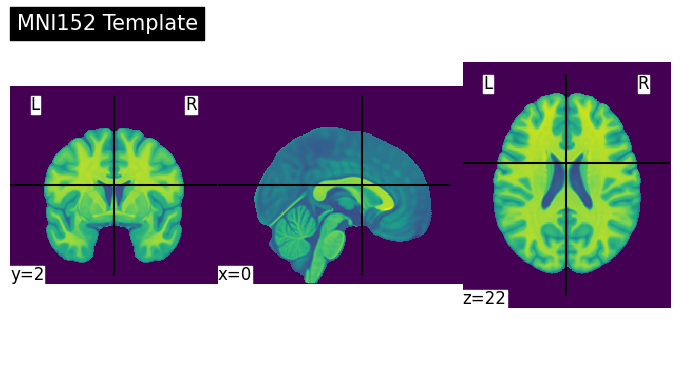

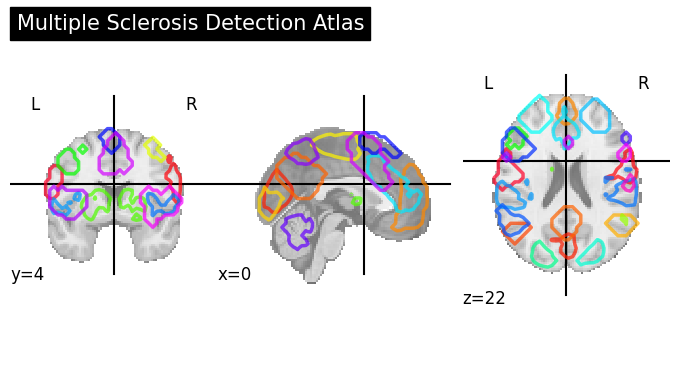

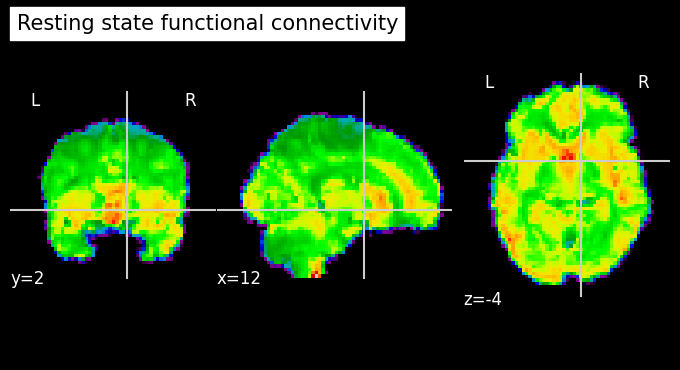

In [5]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import nilearn
from nilearn import plotting
from nilearn import datasets


# Load a sample dataset provided by nilearn
# Here we will use the MNI152 template which is a standard MRI brain template
mni152_template = datasets.load_mni152_template()

# Visualize the template
plotting.plot_img(mni152_template, title="MNI152 Template")

# Fetch a dataset of functional connectomes
# We will use the nilearn datasets.fetch_atlas_msdl function to fetch atlas with group brain parcellations
msdl_atlas_dataset = datasets.fetch_atlas_msdl()
msdl_atlas = msdl_atlas_dataset.maps

# Visualize the atlas
plotting.plot_prob_atlas(msdl_atlas, title='Multiple Sclerosis Detection Atlas')

# Fetch resting-state functional connectivity datasets
# We will use the nilearn datasets.fetch_adhd function to fetch some resting-state functional connectivity data
adhd_dataset = datasets.fetch_adhd(n_subjects=1)

# Print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      adhd_dataset.func[0])  # 4D data

# Load the functional connectivity data of the first subject
func_filename = adhd_dataset.func[0]
func_data = nib.load(func_filename)

# Visualize the functional connectivity data
# We will use the mean image as the background to overlay on
mean_func_img = nilearn.image.mean_img(func_filename)
plotting.plot_epi(mean_func_img, title='Resting state functional connectivity')

# Show plots (if not automatically displayed)
plotting.show()


# **Introduction to Graph Neural Networks (GNNs)**

Graph Neural Networks (GNNs) are a category of neural networks designed to perform inference on data that can be structured as graphs. They are particularly powerful for tasks where the data is inherently graph-structured, such as social networks, molecular structures, and, notably, neuroimaging data where the brain's functional and structural connectivity patterns can be represented as graphs.

## **Key Concepts**
### Node
A node in a graph represents an entity. For instance, in neuroimaging, a node could represent a brain region. In mathematical terms, a node is denoted as $v$ in a graph $G$.

### Edge
An edge represents a relationship or connection between two nodes. In neuroimaging, an edge could represent a functional or structural connectivity *(e.g. Pearson's correlation cofficient)* between two brain regions. Mathematically, an edge is denoted as $(u, v)$, connecting node $u$ to node $v$.

### Graph
A graph is defined by a set of nodes and a set of edges. Each edge connects a pair of nodes. A graph $G$ is typically defined as $G = (V, E)$, where $V$ is the set of nodes and $E$ is the set of edges.





## **Examples of Graph Neural Networks**

### **Graph Convolutional Networks (GCNs)**
GCNs generalize convolutional neural networks (CNNs) to work on graph data. They operate by aggregating information from a node's neighbors to learn a representation of the node.

**GCN Operation**

The basic operation of a GCN on a node $v$ can be described by the following equation:

$$
h_v^{(l+1)} = \sigma \left( W^{(l)} \sum_{u \in \mathcal{N}(v)} \frac{1}{c_{uv}} h_u^{(l)} + b^{(l)} \right)
$$

where:
- $h_v^{(l+1)}$ is the feature representation of node $v$ at layer $l+1$.
- $\sigma$ is a non-linear activation function, such as ReLU.
- $W^{(l)}$ and $b^{(l)}$ are the trainable weight and bias at layer $l$.
- $\mathcal{N}(v)$ is the set of neighbors of $v$.
- $c_{uv}$ is a normalization constant (often the degree of the node).



In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv


def get_y(dataset):
    """
    Get the y values from a list of Data objects.
    """
    y = []
    for d in dataset:
        y.append(d.y.numpy())
    return np.array(y)

# Load a dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(f'Number of graphs: {len(dataset)}')
print("Number and count of classes: ", np.unique(get_y(dataset).flatten(), return_counts=True))
print("Number of node features: ", dataset.num_node_features)
print(f'Number of edge features: {dataset.num_edge_features}')


# Define a GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Number of graphs: 1
Number and count of classes:  (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([351, 217, 418, 818, 426, 298, 180], dtype=int64))
Number of node features:  1433
Number of edge features: 0


In [3]:
# Initialize the model
GCN_model = GCN()
print(GCN_model)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GCN_model = GCN_model.to(device)
data = dataset[0].to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Epoch 1, Loss: 1.958, Accuracy: 0.079
Epoch 11, Loss: 1.149, Accuracy: 0.733
Epoch 21, Loss: 0.617, Accuracy: 0.851
Epoch 31, Loss: 0.383, Accuracy: 0.897
Epoch 41, Loss: 0.326, Accuracy: 0.897
Epoch 51, Loss: 0.268, Accuracy: 0.924
Epoch 61, Loss: 0.242, Accuracy: 0.922
Epoch 71, Loss: 0.211, Accuracy: 0.927
Epoch 81, Loss: 0.195, Accuracy: 0.939
Epoch 91, Loss: 0.185, Accuracy: 0.937
Epoch 101, Loss: 0.185, Accuracy: 0.936
Epoch 111, Loss: 0.171, Accuracy: 0.939
Epoch 121, Loss: 0.157, Accuracy: 0.944
Epoch 131, Loss: 0.160, Accuracy: 0.942
Epoch 141, Loss: 0.150, Accuracy: 0.949
Epoch 151, Loss: 0.132, Accuracy: 0.952
Epoch 161, Loss: 0.124, Accuracy: 0.958
Epoch 171, Loss: 0.135, Accuracy: 0.950
Epoch 181, Loss: 0.132, Accuracy: 0.950
Epoch 191, Loss: 0.125, Accuracy: 0.956


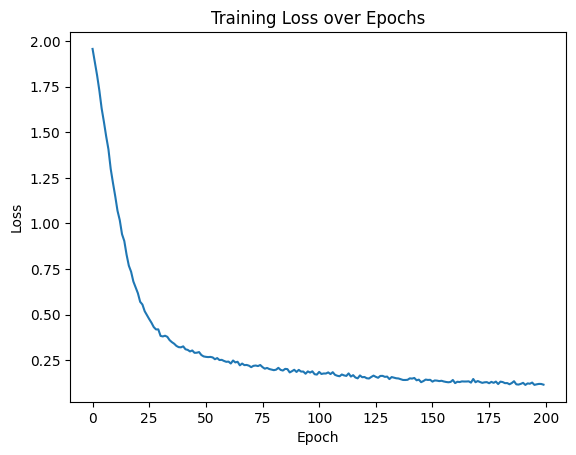

In [4]:
# Train the model
GCN_model.train()
loss_history =[]

for epoch in range(200):
    # Initialize variables to track the loss and accuracy for each epoch
    epoch_loss = 0.0
    epoch_correct_predictions = 0
    epoch_total_predictions = 0

    # Loop over each batch from the data loader
    for batch in dataset:
        # Move batch to device
        batch = batch.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        out = GCN_model(batch)
        # Calculate loss
        loss = criterion(out, batch.y)
        epoch_loss += loss.item()
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Update the weights
        optimizer.step()
        # Calculate the number of correct predictions
        predictions = out.argmax(dim=1)
        epoch_correct_predictions += (predictions == batch.y).sum().item()
        epoch_total_predictions += len(batch.train_mask)

    # Calculate the average loss and accuracy for the epoch
    epoch_loss /= len(dataset)
    loss_history.append(epoch_loss)
    epoch_accuracy = epoch_correct_predictions / epoch_total_predictions

    if epoch % 10 == 0: # Print every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}')

# Plot training loss history over epochs
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

### **Graph Attention Networks (GATs)**
GATs introduce the mechanism of attention to GNNs by each node to weigh its neighboring nodes' contributions differently.

**GAT Operation**

The key operation of a GAT can be described by the following equation:

$$
h_v^{(l+1)} = \sigma \left( \sum_{u \in \mathcal{N}(v)} \alpha_{uv} W^{(l)} h_u^{(l)} \right)
$$

where:
- $\alpha_{uv}$ is the attention coefficient that indicates the importance of node $u$'s features to node $v$.
- $W^{(l)}$ is the trainable weight matrix at layer $l$.
- $h_u^{(l)}$ is the feature representation of node $u$ at layer $l$.
- The attention coefficients $\alpha_{uv}$ are typically computed using a parametric function of the node features, which is learned during training.


In [ ]:
from torch_geometric.nn import GATConv

# Define a GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, dataset.num_classes, heads=1, concat=True, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GAT model
gat_model = GAT()
print(gat_model)

In [ ]:
# Move to GPU if available
gat_model = gat_model.to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

# Train the GAT model
gat_model.train()
loss_history =[]

for epoch in range(200):
    # Initialize variables to track the loss and accuracy for each epoch
    epoch_loss = 0.0
    epoch_correct_predictions = 0
    epoch_total_predictions = 0

    # Loop over each batch from the data loader
    for batch in dataset:
        # Move batch to device
        batch = batch.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        out = gat_model(batch)
        # Calculate loss
        loss = criterion(out, batch.y)
        epoch_loss += loss.item()
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Update the weights
        optimizer.step()
        # Calculate the number of correct predictions
        predictions = out.argmax(dim=1)
        epoch_correct_predictions += (predictions == batch.y).sum().item()
        epoch_total_predictions += len(data.train_mask)

    # Calculate the average loss and accuracy for the epoch
    epoch_loss /= len(dataset)
    loss_history.append(epoch_loss)
    epoch_accuracy = epoch_correct_predictions / epoch_total_predictions

    if epoch % 10 == 0: # Print every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}')

# Plot training loss history over epochs
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

# Test GAT model on the first sample in the dataset
gat_model.eval()
_, pred = gat_model(data).max(dim=1)

# Get the embeddings
embeddings = gat_model.conv1(data.x, data.edge_index)

# Reduce the embeddings to 2 dimensions using t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=pred.cpu().numpy(), cmap='Set1')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


*We observe good separation of all 7 classes due to a high classification performance of the GAT model.*

## **Applications to Neuroimaging**
Preface: In neuroimaging, GNNs can be used to analyze brain connectivity patterns. Each brain region can be represented as a node, and the connections (either structural or functional) between regions are the edges. GNNs can help in tasks such as:

*  Classification of cognitive states or disorders.
*  Regression tasks to predict behavioral or genetic traits.
*  Clustering or community detection within brain networks.



## **ABIDE Classification & Regression Tasks**

The Autism Brain Imaging Data Exchange (ABIDE) dataset provides previously collected resting state functional magnetic resonance imaging datasets from 539 individuals with ASD and 573 typical controls for the purpose of data sharing in the broader scientific community. This grass-root initiative involved 16 international sites, sharing 20 samples yielding 1112 datasets composed of both MRI data and an extensive array of phenotypic information common across nearly all sites (see below).

Note that this is the preprocessed version of ABIDE provided by the Preprocessed Connectome Project (PCP).

For more information about this dataset's structure: http://preprocessed-connectomes-project.github.io http://www.childmind.org/en/healthy-brain-network/abide/

Nielsen, Jared A., et al. "Multisite functional connectivity MRI classification of autism: ABIDE results." Frontiers in human neuroscience 7 (2013).



**Note:** The ABIDE dataaset consumes a lot of storage space so we will provide pre-parcellated connectivity matrices below. Let's run through the steps we used to do so on a single subject.

In [7]:
# Fetch the ABIDE dataset
abide = datasets.fetch_abide_pcp(n_subjects=1, pipeline="cpac",
                                 derivatives=['func_preproc'],
                                 quality_checked=True,
                                 legacy_format=False)


In [8]:
# Store the filenames of the functional scans
fmri_filenames = abide.func_preproc

# Check the number of subject functional scans fetched
print(f"Number of subjects: {len(fmri_filenames)}")

Number of subjects: 1


We need to decide which parcellation to use for rs-fMRI data. We are going to use the [AAL atlas](https://www.sciencedirect.com/science/article/pii/S1053811901909784).

Number of ROIs: 116


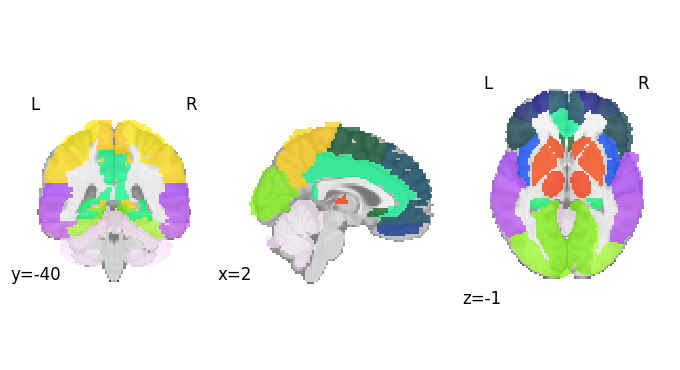

In [9]:
from nilearn import plotting

# Retrieve brain atlas for parcellation
parcellations = datasets.fetch_atlas_aal()
atlas_filename = parcellations.maps
labels = parcellations.labels
print(f"Number of ROIs: {len(labels)}")

# Plot atlas
plotting.plot_roi(atlas_filename, draw_cross=False)

Select a single subject's scan to check information.

In [10]:
sample_subject = abide.func_preproc[0]
sample_subject

'C:\\Users\\yuzho/nilearn_data\\ABIDE_pcp\\cpac\\nofilt_noglobal\\Pitt_0050003_func_preproc.nii.gz'

Using NiftiLabelsMasker we will create a mask on our functional images with the labels of the chosen atlas and extract the time series in each ROI. Because the data is already preprocessed, we do not need to regress out any confounds.

In [11]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename,
                           standardize='zscore_sample',  #z-score each sample to zero mean scaled to unit variance w.r.t. sample std
                           memory='nilearn_cache',
                           verbose=0)

time_series = masker.fit_transform(sample_subject)

C:\Users\yuzho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Now we are going to extract the connectivity matrix for each sample using the pre-defined masker.

In [12]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
connectivity_matrix = correlation_measure.fit_transform([time_series])[0]
print(f"Connectivity matrix shape: {connectivity_matrix.shape}")

Connectivity matrix shape: (116, 116)


C:\Users\yuzho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nilearn\connectome\connectivity_matrices.py:509: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


...and plot it.

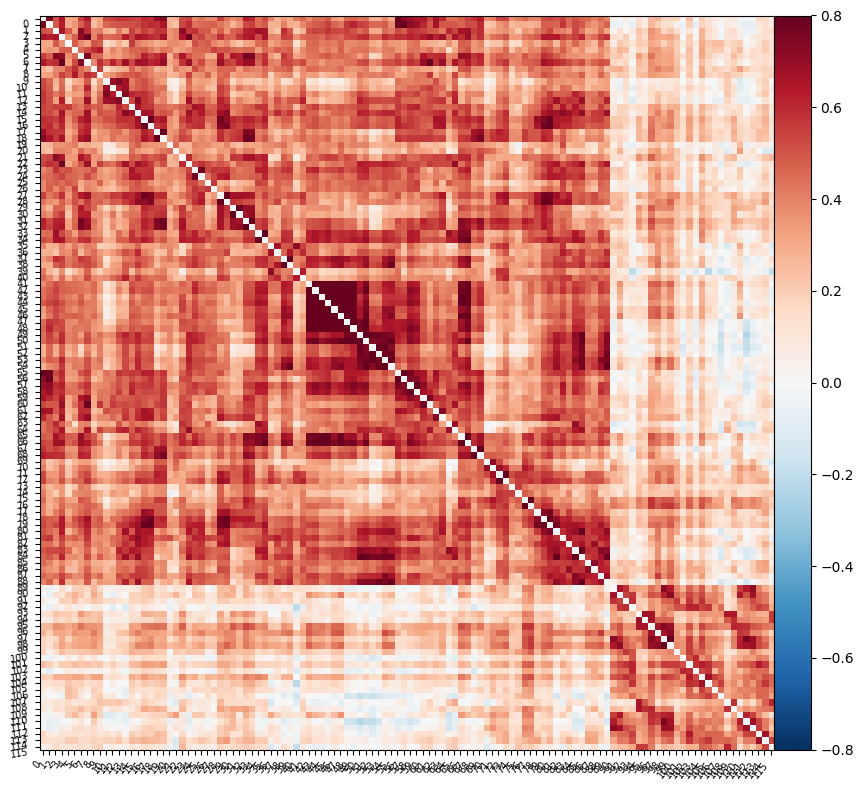

In [13]:
import numpy as np

np.fill_diagonal(connectivity_matrix, 0)

plotting.plot_matrix(connectivity_matrix, figure=(10, 8),
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

In [26]:
# @title Load parcellated, connectivity matrices as our features, X
import numpy as np
import pandas as pd

# Load the connectivity matrices
conn_matrices = './ABIDE_conn_matrices.npz'
X = np.load(conn_matrices)['a']

with open('./ABIDE_preproc_300.pkl', 'rb') as f:
    abide = pd.read_pickle(f)

# Store the filenames of the functional scans
fmri_filenames = abide.func_preproc

# Check the number of subject functional scans fetched
print(f"Number of subjects: {len(fmri_filenames)}")

Number of subjects: 300


Now we have the connectivity matrices for all subjects. Let's see the shape of our connectivity matrices.

In [15]:
X.shape

(300, 116, 116)

Accompanying the data set is a csv file containing the phenotypic data. According to the Phenotypic Data Legend which can be downloaded [here](http://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html), the column DX_GROUP has the information about the diagnostic group each participant is in. It is coded as:

*   1 = Autism
*   2 = Control

Let's import the csv.

In [16]:
import pandas as pd
phenotypic = pd.read_csv("./Phenotypic_V1_0b_preprocessed1.csv")

Let's use the file names to get the right values from the DX_GROUP column.

In [17]:
file_ids = []

# Get the file IDs from the file names
for f in fmri_filenames:
    file_ids.append(f[-27:-20])

# Get labels for autism diagnosis => classification task
y_asd = []
for i in range(len(phenotypic)):
    for j in range(len(file_ids)):
        if file_ids[j] in phenotypic.FILE_ID[i]:
            y_asd.append(phenotypic.DX_GROUP[i])

# Get labels for full-scale IQ (FIQ) => regression task
y_fiq = []
for i in range(len(phenotypic)):
    for j in range(len(file_ids)):
        if file_ids[j] in phenotypic.FILE_ID[i]:
            y_fiq.append(phenotypic.FIQ[i])
            

print(f'y_asd: {y_asd}')
print(f'y_fiq: {y_fiq}')

y_asd: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
y_fiq: [124.0, 113.0, 119.0, 109.0, 110.0, 123.0, 81.0, 111.0, 128.0, 86.0, 96.0, 99.0, 123.

Now, we're ready to prepare out data for graph learning. We will first create a custom PyTorch Geometric dataset to convert connectivity matrices, X to edge index and edge attributes for our graphs.

In [18]:
# @title Create custom PyG ConnectomeDataset
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import dense_to_sparse

class ConnectomeDataset(Dataset):
    def __init__(self, connectivity_matrices, labels, task="classification", transform=None, pre_transform=None):
        super(ConnectomeDataset, self).__init__(None, transform, pre_transform)
        self.connectivity_matrices = connectivity_matrices
        self.labels = labels
        self.task = task

    def len(self):
        return len(self.connectivity_matrices)

    def get(self, idx):
        # Convert the connectivity matrix to edge index and edge attributes
        connectivity_matrix = torch.tensor(self.connectivity_matrices[idx])
        edge_index, edge_attr = dense_to_sparse(connectivity_matrix)

        # Create a data object
        data = Data(edge_index=edge_index, edge_attr=edge_attr)
        data.x = connectivity_matrix.to(torch.float)
        if self.task == "classification":
          data.y = torch.tensor([self.labels[idx]-1], dtype=torch.long) # make labels start at 0
        else:
          data.y = torch.tensor([self.labels[idx]], dtype=torch.float)
        return data

### Classification Task

In [32]:
import torch
import torch_geometric.transforms as T
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

# Instantiate the dataset
abide_dataset_asd = ConnectomeDataset(X, y_asd)
# print(abide_dataset_asd)
loader = DataLoader(abide_dataset_asd, batch_size=32, shuffle=True)
# for i in loader:
#     print(i)
#     print(i.y)

print(f'Number of graphs: {len(abide_dataset_asd)}')
print("Number and count of classes: ", np.unique(get_y(abide_dataset_asd).flatten(), return_counts=True))
print("Number of node features: ", abide_dataset_asd.num_node_features)
print(f'Number of edge features: {abide_dataset_asd.num_edge_features}')

num_classes = 2

# Define a GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(abide_dataset_asd.num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # Apply global mean pooling to get a single vector for the whole graph
        x = global_mean_pool(x, batch=data.batch)
        # x = F.log_softmax(x, dim=1)

        return x

Number of graphs: 300
Number and count of classes:  (array([0, 1], dtype=int64), array([124, 176], dtype=int64))
Number of node features:  116
Number of edge features: 1


In [30]:
# Initialize the model
GCN_model = GCN()
print(GCN_model)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
GCN_model = GCN_model.to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, GCN_model.parameters()),
            lr=0.01,
            weight_decay=0.0001
        )

GCN(
  (conv1): GCNConv(116, 16)
  (conv2): GCNConv(16, 2)
)
cuda


Epoch 1, Loss: 0.688, Accuracy: 0.590
Epoch 11, Loss: 0.687, Accuracy: 0.603
Epoch 21, Loss: 0.663, Accuracy: 0.587
Epoch 31, Loss: 0.641, Accuracy: 0.610
Epoch 41, Loss: 0.625, Accuracy: 0.673
Epoch 51, Loss: 0.608, Accuracy: 0.683
Epoch 61, Loss: 0.587, Accuracy: 0.693
Epoch 71, Loss: 0.578, Accuracy: 0.690
Epoch 81, Loss: 0.585, Accuracy: 0.680
Epoch 91, Loss: 0.561, Accuracy: 0.717
Epoch 101, Loss: 0.557, Accuracy: 0.700
Epoch 111, Loss: 0.532, Accuracy: 0.703
Epoch 121, Loss: 0.554, Accuracy: 0.727
Epoch 131, Loss: 0.514, Accuracy: 0.727
Epoch 141, Loss: 0.572, Accuracy: 0.677
Epoch 151, Loss: 0.526, Accuracy: 0.733
Epoch 161, Loss: 0.510, Accuracy: 0.760
Epoch 171, Loss: 0.510, Accuracy: 0.730
Epoch 181, Loss: 0.493, Accuracy: 0.737
Epoch 191, Loss: 0.494, Accuracy: 0.760


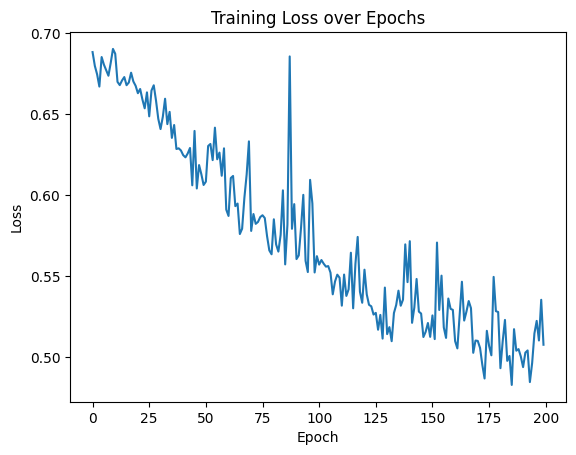

In [21]:
# Train the model
GCN_model.train()
loss_history =[]

for epoch in range(200):
    # Initialize variables to track the loss and accuracy for each epoch
    epoch_loss = 0.0
    epoch_correct_predictions = 0
    epoch_total_predictions = 0

    # Loop over each batch from the data loader
    for batch in loader:
        # Move batch to device
        batch = batch.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        out = GCN_model(batch)
        # Calculate loss
        loss = criterion(out, batch.y)
        epoch_loss += loss.item()
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Update the weights
        optimizer.step()
        # Calculate the number of correct predictions
        _, pred = torch.max(out, 1)
        epoch_correct_predictions += (pred == batch.y).sum().item()
        epoch_total_predictions += batch.y.size(0)

    # Calculate the average loss and accuracy for the epoch
    epoch_loss /= len(loader)
    loss_history.append(epoch_loss)
    epoch_accuracy = epoch_correct_predictions / epoch_total_predictions

    if epoch % 10 == 0: # Print every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}')

# Plot training loss history over epochs
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

### Comparison to Baseline

Let's compare our model's performance to a baseline traditional ML method.

In [ ]:
from sklearn.model_selection import train_test_split

X_bl = X.reshape(X.shape[0], -1)
X_train, X_val, y_train, y_val = train_test_split(X_bl, # x
                                                  y_asd, # y
                                                  test_size = 0.4, # 60%/40% split
                                                  shuffle = True, # shuffle dataset before splitting
                                                  stratify = y_asd,  # keep distribution of ASD consistent between sets
                                                  random_state = 123 # same split each time
                                                 )

We are going to use the Linear Support Vector Classifier (SVC) and cross-validation to estimate our average accuracy.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict, cross_val_score

l_svc = LinearSVC(max_iter=100000) # more iterations than the default
l_svc.fit(X_train, y_train)

# predict
y_pred_svc = cross_val_predict(l_svc, X_train, y_train, cv=10)

# scores
acc_svc = cross_val_score(l_svc, X_train, y_train, cv=10)

print("Avg accuracy:", acc_svc.mean())

### Regression Task

Now, we'll do a regression task for predicting the full-scale intelligence (FIQ) of the subjects.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize labels due to highly varied range
y_fiq = np.array(y_fiq).reshape(-1, 1)
y_fiq = StandardScaler().fit_transform(y_fiq)

# Use the dataset with a DataLoader for batching
abide_dataset_fiq = ConnectomeDataset(X, y_fiq, task="regression")
train_loader = DataLoader(abide_dataset_fiq[:255], batch_size=16, shuffle=True)
test_loader = DataLoader(abide_dataset_fiq[255:], batch_size=16)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

num_classes = 1

# Define a GATRegModel model
class GATRegressionModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim, heads, dropout=0.0):
        super(GATRegressionModel, self).__init__()
        # Define the first Graph Attention layer
        self.gat1 = GATConv(num_features, hidden_dim, heads, dropout=dropout)
        # Define the second Graph Attention layer
        # For the in_features of the second GAT layer, we multiply hidden_dim by the number of heads
        # because the outputs of all heads from the first layer are concatenated
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False, dropout=dropout)
        # Define the final fully connected layer for regression
        self.regressor = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # Apply the first GAT layer with ELU activation
        x = F.elu(self.gat1(x, edge_index))

        # Apply dropout
        x = F.dropout(x, p=self.gat1.dropout, training=self.training)

        # Apply the second GAT layer with ELU activation
        x = self.gat2(x, edge_index)
        x = F.elu(x)

        # Apply global mean pooling to get a single vector for the whole graph
        x = global_mean_pool(x, data.batch)

        # Apply the final regressor layer to predict the continuous value
        x = self.regressor(x)

        return x

In [ ]:
# Initialize the model
GATReg_model = GATRegressionModel(
    num_features=abide_dataset_fiq.num_features, hidden_dim=64,
    output_dim=1, heads=4, dropout=0.5)
GATReg_model.to(device)  # Move model to the appropriate device (CPU or GPU)

# Print the model summary
print(GATReg_model)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GATReg_model = GATReg_model.to(device)

# Define loss and optimizer
optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, GATReg_model.parameters()),
            lr=0.001,
            weight_decay=0.0001
        )

In [ ]:
# Train model function
def train():
    GATReg_model.train()
    epoch_loss = 0.0
    all_predictions = []
    all_targets = []

    for data in abide_dataset_fiq[:255]:
        data.to(device)  # Move batch to the appropriate device
        optimizer.zero_grad()  # Zero the gradients
        out = GATReg_model(data.x, data.edge_index)  # Forward pass, here you call the model with the batch, not the forward method directly
        loss = F.mse_loss(out, data.y)  # Compute loss, Mean Squared Error loss for regression
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        epoch_loss += loss.item()
        # Store predictions and targets to calculate metrics later
        all_predictions.append(out.detach())
        all_targets.append(batch.y.detach())

    # Concatenate all predictions and targets
    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()

    # Calculate the average loss and accuracy for the epoch
    epoch_loss /= len(train_loader)
    loss_history.append(epoch_loss)

    return epoch_loss

# Test model function
@torch.no_grad()
def test(dataset):
    GATReg_model.eval()
    mse = []
    for data in dataset:
        data.to(device)  # Move batch to the appropriate device
        out = GATReg_model(data.x, data.edge_index)

    mse.append(F.mse_loss(out, data.y, reduction='none').cpu())

    return float(torch.cat(mse, dim=0).mean().sqrt())


In [ ]:
# Train and validate the model
loss_history, rmses = [], []

for epoch in range(100):
  loss = train()
  loss_history.append(loss)
  train_rmse = test(abide_dataset_fiq[:255]) # 85% of dataset for train
  test_rmse = test(abide_dataset_fiq[255:]) # 15% of dataset for test
  rmses.append(test_rmse)
  if epoch % 10 == 0: # Print every 10 epochs
    print(f'Epoch: {epoch+1:02d}, Train Loss: {loss:.4f}, Train_RMSE: {train_rmse:.4f}, '
    f'Test RMSE: {test_rmse:.4f}')

# Save model
torch.save(GATReg_model.state_dict(), './GATReg_model_state_dict.pth')

# Plot training loss history over epochs
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

### Brain Network Explanations and Visualization
PyG provides tools to explain the predictions of a PyG model or to explain the underlying phenomenon of a dataset (see the [“GraphFramEx: Towards Systematic Evaluation of Explainability Methods for Graph Neural Networks”](https://arxiv.org/abs/2206.09677) paper for more details).

Explanations can be represented using the `torch_geometric.explain.Explanation` class, which is a `Data` object containing masks for the nodes, edges, features and any attributes of the data.

The `torch_geometric.explain.Explainer` class is designed to handle all explainability parameters (see the `torch_geometric.explain.config.ExplainerConfig` class for more details):
* which algorithm from the `torch_geometric.explain.algorithm` module to use (e.g., `GNNExplainer`)
* the type of explanation to compute (e.g., `explanation_type="phenomenon"` or `explanation_type="model"`)
* the different type of masks for node and edges (e.g., `mask="object"` or `mask="attributes"`)
* any postprocessing of the masks (e.g., `threshold_type="topk"` or `threshold_type="hard"`)

This allows the user to easily compare different explainability methods and to easily switch between different types of masks, while making sure the high-level framework stays the same.

Let's take a look at how to explain our model's predictions and visualize the inference...

In [ ]:
from torch_geometric.explain import AttentionExplainer, Explainer

# Load saved model
GATReg_model = GATRegressionModel( # Pass in same configs as when initalized
    num_features=abide_dataset_fiq.num_features, hidden_dim=64,
    output_dim=1, heads=4, dropout=0.5)
GATReg_model = GATReg_model.to(device)

# Load saved model and weights
GATReg_model.load_state_dict(torch.load('./GATReg_model_state_dict.pth'))

# Get model ready for evaluation
GATReg_model.eval()

# Initialize the Explainer
explainer = Explainer(
        model=GATReg_model,
        algorithm=AttentionExplainer(),
        explanation_type='model',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
    )

# See an explanation for the first sample in the dataset:
explanation = explainer(x=abide_dataset_fiq[0].x.to(device), edge_index=abide_dataset_fiq[0].edge_index.to(device))

# See the corresponding explanation subgraph items
print(explanation.get_explanation_subgraph())

In [ ]:
'''
Adapted from sano_eeg (2023)
Source: https://github.com/szmazurek/sano_eeg/blob/a15d397c51d46bf6b11fdce754a7c2610b757097/src/explainability.ipynb
'''
# Get explanation edge masks for all test samples
test_loader_fiq = abide_dataset_fiq[255:]
edge_connection_dict_all = {}

for n, batch in enumerate(test_loader_fiq):
    # Get explanation for a sample
    explanation = explainer(
        x=batch.x.to(device),
        edge_index=batch.edge_index.to(device)
    )

    # Save edge 'attention' weights
    for edge_idx in range(explanation.edge_index.size(1)):
        edge = explanation.edge_index[:, edge_idx].tolist()
        edge.sort()
        edge = str(tuple(edge))
        edge_mask = explanation.edge_mask[edge_idx].item()
        if edge in edge_connection_dict_all.keys():
            edge_connection_dict_all[edge] += edge_mask
        else:
            edge_connection_dict_all[edge] = edge_mask

edge_connection_dict_all = {key: value / (n+1) for key, value in edge_connection_dict_all.items()}

In [ ]:
import networkx as nx

# Create a N x N graph from edge connections, where N = number of ROIs
def create_graph_from_dict(input_dict, threshold=0.0):
    g = nx.Graph()
    for edge, value in input_dict.items():
        edge = eval(edge)

        if value < threshold: # hard threshold edges < threshold value to 0
            g.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], weight=0)
        else:
            if edge[0] != edge[1]: # no self loops
                g.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], weight=value)
    return g

G = create_graph_from_dict(edge_connection_dict_all) # Get graph with attention weights
A = nx.to_numpy_array(G) # Get N x N array with ROIs as nodes and explanation attention weights as edges

In [ ]:
import numpy as np
import nilearn.plotting as plotting

# Fetch the AAL atlas
aal_atlas = datasets.fetch_atlas_aal()
atlas_img = nib.load(aal_atlas.maps)

# Get the atlas data as a numpy array
atlas_data = atlas_img.get_fdata()

# Get the (x,y,z) coordinates of the centers of the regions, N x 3
roi_coords = plotting.find_parcellation_cut_coords(labels_img=atlas_img)

# Get the names of each ROI, N x 1
roi_labels = np.array(aal_atlas.labels)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
'''
Adapted from sano_eeg (2023)
Source: https://github.com/szmazurek/sano_eeg/blob/a15d397c51d46bf6b11fdce754a7c2610b757097/src/explainability.ipynb
'''
# Visualize the attention weights
custom_labels = {n: roi_labels[n] for n in range(len(roi_labels))}
edge_opacities = [0.2 + weight * 0.8 for weight in nx.get_edge_attributes(G, "weight").values()]
pos = nx.circular_layout(G)

# Create a subplot for the graph and another for the colorbar
fig, ax = plt.subplots()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position and size as needed

# Draw the graph
nx.draw(G, ax=ax, with_labels=True, labels=custom_labels, pos=pos, font_weight="bold",
        edge_color=edge_opacities, width=2, node_size=1000, node_color="white",
        edge_cmap=plt.cm.autumn)

# Create the colorbar
scalar_mappable = plt.cm.ScalarMappable(cmap=plt.cm.autumn)
colorbar = plt.colorbar(scalar_mappable, cax=cax)

color = "white"
colorbar.set_label(label="Connection Strength", color=color)
colorbar.ax.yaxis.set_tick_params(color=color, labelcolor=color)
fig = plt.gcf()
fig.set_facecolor("black")  # Set the background color here
plt.savefig('./vis_attn.png')


In [ ]:
'''
Adapted from xGW-GAT by Favour Nerrise (2023)
Source: https://github.com/favour-nerrise/xGW-GAT/blob/main/src/utils/visualization.py
'''
# Export attention weights .node and .edge files for BrainNetViewer
def to_brainnet(
    edges,
    roi_xyz,
    roi_labels,
    C=None,
    S=None,
    path=".",
    prefix="bnv",
):
    """Export data to plaintext file(s) for use with BrainNet Viewer.
    Source:  https://www.nitrc.org/projects/bnv/
    For details regarding .node and .edge file construction, the
    user is directed to the BrainNet Viewer User Manual.
    Manual: https://www.nitrc.org/docman/view.php/504/77994/BrainNet%20Viewer%20Manual%201.61.pdf
    This code was quality tested using BrainNet version 1.7 released on
    2019-10-31 with MATLAB R2023b.
    Parameters:
    -----------
    edges : numpy array
        N x N matrix containing important edge weights/attention weights.
    roi_xyz : pandas dataframe
        N x 3 dataframe containing the (x, y, z) MNI coordinates of each
        brain ROI.
    roi_names : pandas series
        N x 1 list of ROI labels as string.
    C : pandas series
        Node color value (defaults to same color). For modular color,
        use integers; for continuous data use floats.
    S : pandas series
        Node size value (defaults to same size).
    path : string
        Path to output directory (default is current directory). Note:
        do not include trailing '/' at end.
    prefix : string
        Filename prefix for output files.
    Returns
    -------
    <prefix>.node, <prefix>.edge : files
        Plaintext output files for input to BrainNet.
    References
    ----------
    [1] Xia M, Wang J, He Y (2013) BrainNet Viewer: A Network
        Visualization Tool for Human Brain Connectomics. PLoS ONE 8:
        e68910.
    """

    N = len(roi_xyz)  # number of nodes/ROIs

    if C is None:
        C = np.ones(N)

    if S is None:
        S = np.ones(N)

    # BrainNet does not recognize node labels with white space, replace
    # spaces with underscore
    labels = roi_labels.str.replace(" ", "_").to_list()

    # Build .node dataframe
    df = roi_xyz.copy()
    df = df.assign(C=C).assign(S=S).assign(labels=labels)

    # Output .node file
    df.to_csv(f"{path}/{prefix}.node", sep="\t", header=False, index=False)
    print(f"Saved {path}/{prefix}.node")

    # Output .edge file
    np.savetxt(f"{path}/{prefix}.edge", edges, delimiter="\t")
    print(f"Saved {path}/{prefix}.edge")

ROIs have been assigned to one of 6 resting-state functional networks, roughly:
1. Tempo-Parietal Network
2. Occipital Network
3. Fronto-Parietal Network
4. Default Mode Network (DMN)
5. Basal Ganglia, Limbic Network, & Thalamus
6. Cerebellum

Source: 
https://github.com/mingruixia/BrainNet-Viewer/blob/9694ebd75d8a82cae5f0334f4d0d88e0bc91437a/Data/ExampleFiles/AAL90/Node_AAL116.node

In [ ]:
# Get ROI and resting-state functional network info + explanation attention weights
roi_coords_df = pd.DataFrame(roi_coords)
roi_labels_short = pd.read_csv('./ROI_RSNNetworks.csv')["ROI"]
roi_labels_network = pd.read_csv('./ROI_RSNNetworks.csv')["Network"].to_numpy()

# Create .node and .edge files for BrainNetViewer
to_brainnet(A, roi_coords_df, roi_labels_short, roi_labels_network)